In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------
# Encoder block: uses LeakyReLU as before
# -------------------------------
class pix2pix_conv_block(nn.Module):
    """
    A double convolution block using 3x3 filters.
    Uses LeakyReLU activations (negative slope 0.2).
    Optionally applies BatchNorm.
    
    The first convolution outputs 'base_channels'
    and the second outputs 'base_channels * 2'.
    """
    def __init__(self, in_channels, base_channels, use_batchnorm=True):
        super(pix2pix_conv_block, self).__init__()
        layers = []
        # First convolution: outputs base_channels
        layers.append(nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1, bias=True))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(base_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        # Second convolution: outputs base_channels * 2
        layers.append(nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=1, padding=1, bias=True))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(base_channels * 2))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv(x)

# -------------------------------
# Decoder conv block: uses only ReLU
# -------------------------------
class pix2pix_conv_block_decoder(nn.Module):
    """
    A double convolution block for the decoder using 3x3 filters.
    Uses ReLU activations.
    Optionally applies BatchNorm.
    
    The first convolution outputs 'base_channels'
    and the second outputs 'base_channels * 2'.
    """
    def __init__(self, in_channels, base_channels, use_batchnorm=True):
        super(pix2pix_conv_block_decoder, self).__init__()
        layers = []
        # First convolution: outputs base_channels
        layers.append(nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1, bias=True))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(base_channels))
        layers.append(nn.ReLU(inplace=True))
        # Second convolution: outputs base_channels * 2
        layers.append(nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=1, padding=1, bias=True))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(base_channels * 2))
        layers.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv(x)

# -------------------------------
# Upsampling block (decoder): already uses ReLU
# -------------------------------
class pix2pix_up_conv_decoder(nn.Module):
    """
    Decoder block with a 4x4 transpose convolution followed by BatchNorm and ReLU.
    This block does not double the filter size during decoding.
    """
    def __init__(self, in_channels, out_channels, use_dropout=False):
        super(pix2pix_up_conv_decoder, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        self.up = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.up(x)

# -------------------------------
# Modified UNetPix2PixGenerator
# -------------------------------
class UNetGenerator(nn.Module):
    def __init__(self, img_channels=1, output_channels=1):
        super(UNetGenerator, self).__init__()
        # Encoder (input resolution: 48x48)
        self.enc1 = pix2pix_conv_block(img_channels, 4, use_batchnorm=False)  # Output: 8 channels, 48x48
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                     # 48 -> 24
        self.enc2 = pix2pix_conv_block(8, 8, use_batchnorm=True)                # Output: 16 channels, 24x24
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                     # 24 -> 12
        self.enc3 = pix2pix_conv_block(16, 16, use_batchnorm=True)              # Output: 32 channels, 12x12
        
        # Reduce latent channels from 32 to 16:
        self.reduce = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0)
        
        # Decoder
        self.up1 = pix2pix_up_conv_decoder(16, 16, use_dropout=True)           # 12x12 -> 24x24
        self.reduce1 = nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0)    # Reduce channels before dec1
        self.dec1 = pix2pix_conv_block_decoder(16, 16, use_batchnorm=True)      # Uses ReLU; concatenated with enc2 (16+16)
        
        self.up2 = pix2pix_up_conv_decoder(32, 8, use_dropout=True)            # 24x24 -> 48x48 (input from dec1 is 32 channels)
        self.reduce2 = nn.Conv2d(16, 8, kernel_size=1, stride=1, padding=0)     # Reduce channels before dec2
        self.dec2 = pix2pix_conv_block_decoder(8, 8, use_batchnorm=True)        # Uses ReLU; concatenated with enc1 (8+8)
        
        self.final_conv = nn.Conv2d(16, output_channels, kernel_size=1, stride=1, padding=0)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)       # [B, 8, 48, 48]
        p1 = self.pool1(x1)     # [B, 8, 24, 24]
        x2 = self.enc2(p1)      # [B, 16, 24, 24]
        p2 = self.pool2(x2)     # [B, 16, 12, 12]
        x3 = self.enc3(p2)      # [B, 32, 12, 12]  <- Latent space before reduction
        x3 = self.reduce(x3)    # [B, 16, 12, 12]  <- Reduced latent space
        
        # Decoder
        up1 = self.up1(x3)      # [B, 16, 24, 24]
        cat1 = torch.cat([up1, x2], dim=1)  # [B, 32, 24, 24]  
        cat1 = self.reduce1(cat1)  # Reduce channels from 32 to 16 [B, 16, 24, 24]
        dec1 = self.dec1(cat1)     # [B, 32, 24, 24] (decoder conv block doubles channels)
        
        up2 = self.up2(dec1)    # [B, 8, 48, 48]
        cat2 = torch.cat([up2, x1], dim=1)  # [B, 16, 48, 48]
        cat2 = self.reduce2(cat2)  # Reduce channels from 16 to 8 [B, 8, 48, 48]
        dec2 = self.dec2(cat2)     # [B, 16, 48, 48]
        
        out = self.final_conv(dec2)   # [B, output_channels, 48, 48]
        out = self.final_activation(out)
        return out

# -------------------------------
# (Optional) Weight Initialization Function
# -------------------------------
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and ('Conv' in classname or 'Linear' in classname):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError(f'initialization method [{init_type}] is not implemented')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetGenerator(img_channels=1, output_channels=1).to(device)
init_weights(model)

# Display model summary
from torchsummary import summary
summary(model, (1, 48, 48))  # Input shape: (channels, height, width)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 48, 48]              40
         LeakyReLU-2            [-1, 4, 48, 48]               0
            Conv2d-3            [-1, 8, 48, 48]             296
         LeakyReLU-4            [-1, 8, 48, 48]               0
pix2pix_conv_block-5            [-1, 8, 48, 48]               0
         MaxPool2d-6            [-1, 8, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             584
       BatchNorm2d-8            [-1, 8, 24, 24]              16
         LeakyReLU-9            [-1, 8, 24, 24]               0
           Conv2d-10           [-1, 16, 24, 24]           1,168
      BatchNorm2d-11           [-1, 16, 24, 24]              32
        LeakyReLU-12           [-1, 16, 24, 24]               0
pix2pix_conv_block-13           [-1, 16, 24, 24]               0
        MaxPool2d-14           [-1, 16

In [3]:
!pip install opencv-python-headless torchsummary # For install cv2

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached torchsummary-1.5.1-py3-none-any.whl.metadata (296 bytes)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [2]:
import torch
import torch.nn as nn

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=1):
        """
        in_channels: number of channels in the input images (e.g., 1 for grayscale).
        After concatenating the input and target images, the input becomes 2*in_channels.
        """
        super(PatchGANDiscriminator, self).__init__()
        # Layer 1: From 2 channels (concatenated input) to 4 channels at 48x48.
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels * 2, 4, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )  # Output: 48x48x4

        # Layer 2: Maintain 48x48, increase channels from 4 to 8.
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True)
        )  # Output: 48x48x8

        # Layer 3: Downsample to 24x24 while keeping 8 channels.
        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2, inplace=True)
        )  # Output: 24x24x8

        # Layer 4: At 24x24, increase channels from 8 to 16.
        self.layer4 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True)
        )  # Output: 24x24x16

        # Layer 5: Downsample to 12x12 while keeping 16 channels.
        self.layer5 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True)
        )  # Output: 12x12x16

        # Layer 6: At 12x12, increase channels from 16 to 32.
        self.layer6 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True)
        )  # Output: 12x12x32

        # Layer 7: Final layer to produce a single-channel patch-map.
        self.layer7 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )  # Output: 12x12x1

    def forward(self, input_image, target_image):
        # Concatenate input and target along the channel dimension:
        # (batch, 2*in_channels, 48, 48)
        x = torch.cat([input_image, target_image], dim=1)
        x = self.layer1(x)  # 48x48x4
        x = self.layer2(x)  # 48x48x8
        x = self.layer3(x)  # 24x24x8
        x = self.layer4(x)  # 24x24x16
        x = self.layer5(x)  # 12x12x16
        x = self.layer6(x)  # 12x12x32
        x = self.layer7(x)  # 12x12x1
        return x


In [3]:
import numpy as np

# Load the .npy files
original_images = np.load('data/train_patches_48x48x25/original_patches.npy')
clean_images = np.load('data/train_patches_48x48x25/ground_truth_patches.npy')

# Ensure the data is in the correct shape
print(f'Original images shape: {original_images.shape}')
print(f'Clean images shape: {clean_images.shape}')


Original images shape: (340534, 48, 48)
Clean images shape: (340534, 48, 48)


In [4]:
import torch
from torch.utils.data import Dataset

class ManuscriptDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data  # Original patches (.npy)
        self.target_data = target_data  # Clean patches (.npy)


    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_image = self.input_data[idx]
        target_image = self.target_data[idx]

        # Convert to tensors and normalize to [0, 1]
        input_image = torch.tensor(input_image, dtype=torch.float32).unsqueeze(0) / 255.0
        target_image = torch.tensor(target_image, dtype=torch.float32).unsqueeze(0) / 255.0

        return input_image, target_image


In [5]:
dataset = ManuscriptDataset(original_images, clean_images)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gen = UNetGenerator().to(device)
disc = PatchGANDiscriminator().to(device)

# Loss functions
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training parameters
num_epochs = 2  # Set the number of epochs as needed
lambda_L1 = 100   # Weight for L1 loss component

# Training loop
for epoch in range(num_epochs):
    loop = tqdm(dataloader, leave=True)
    for idx, (input_image, target_image) in enumerate(loop):
        input_image = input_image.to(device)
        target_image = target_image.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Generate fake image
        fake_image = gen(input_image)

        # Discriminator real loss
        D_real = disc(input_image, target_image)
        loss_D_real = criterion_GAN(D_real, torch.ones_like(D_real))

        # Discriminator fake loss
        D_fake = disc(input_image, fake_image.detach())
        loss_D_fake = criterion_GAN(D_fake, torch.zeros_like(D_fake))

        # Total Discriminator loss
        loss_D = (loss_D_real + loss_D_fake) / 2

        # Backpropagation for Discriminator
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        # Generator adversarial loss
        D_fake = disc(input_image, fake_image)
        loss_G_GAN = criterion_GAN(D_fake, torch.ones_like(D_fake))

        # Generator L1 loss
        loss_G_L1 = criterion_L1(fake_image, target_image) * lambda_L1

        # Total Generator loss
        loss_G = loss_G_GAN + loss_G_L1

        # Backpropagation for Generator
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Update progress bar
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(loss_D=loss_D.item(), loss_G=loss_G.item())
        
# Save the model checkpoints
torch.save(gen.state_dict(), 'model_48x48x25/generator_48x48x25.pth')
torch.save(disc.state_dict(), 'model_48x48x25/discriminator_48x48x25.pth')
print("Model training completed!")

Epoch [1/2]: 100%|██████████| 340534/340534 [1:13:50<00:00, 76.87it/s, loss_D=0.693, loss_G=0.693]

Model training completed!


In [10]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_ubyte
import cv2  # OpenCV for PSNR
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = UNetGenerator().to(device)
model.load_state_dict(torch.load('model_48x48x25/generator_48x48x25.pth'))
model.eval()

# Define the dataset and DataLoader
class PatchDataset(Dataset):
    def __init__(self, data_path):
        """
        Dataset for loading pre-extracted patches.
        """
        self.original_patches = np.load(os.path.join(data_path, 'original_patches.npy'))
        self.ground_truth_patches = np.load(os.path.join(data_path, 'ground_truth_patches.npy'))
        self.num_samples = len(self.original_patches)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        original_patch = self.original_patches[idx]
        ground_truth_patch = self.ground_truth_patches[idx]
        # Convert to tensor and normalize to [0, 1]
        original_patch = torch.tensor(original_patch, dtype=torch.float32).unsqueeze(0) / 255.0
        ground_truth_patch = torch.tensor(ground_truth_patch, dtype=torch.float32).unsqueeze(0) / 255.0
        return original_patch, ground_truth_patch

# Helper function for SSIM
def calculate_ssim(output, target):
    output_np = output.squeeze().cpu().numpy()
    target_np = target.squeeze().cpu().numpy()
    # Convert to 8-bit unsigned integers
    output_np = img_as_ubyte(np.clip(output_np, 0, 1))
    target_np = img_as_ubyte(np.clip(target_np, 0, 1))
    return ssim(output_np, target_np, data_range=255.0)

# Initialize the dataset and dataloader
data_path = 'data/test_patches_48x48x25'
patch_dataset = PatchDataset(data_path)
patch_loader = DataLoader(patch_dataset, batch_size=1, shuffle=False)

# Lists to store per-patch metrics
mse_list = []
psnr_list = []
ssim_list = []

# Iterate through the test data
for original_patch, ground_truth_patch in patch_loader:
    original_patch = original_patch.to(device)
    ground_truth_patch = ground_truth_patch.to(device)

    # Predict output from the model
    with torch.no_grad():
        output_patch = model(original_patch)

    # Convert tensors to numpy arrays for metric calculation
    output_np = output_patch.squeeze().cpu().numpy()
    ground_truth_np = ground_truth_patch.squeeze().cpu().numpy()

    # Calculate per-patch MSE
    mse_value = np.mean((output_np - ground_truth_np) ** 2)
    mse_list.append(mse_value)

    # Calculate per-patch PSNR using OpenCV (which uses the formula: 
    # PSNR = 10 * log10(MAX^2 / MSE); here, MAX is determined from the input arrays)
    psnr_value = cv2.PSNR(output_np, ground_truth_np)
    psnr_list.append(psnr_value)

    # Calculate per-patch SSIM
    ssim_value = calculate_ssim(output_patch, ground_truth_patch)
    ssim_list.append(ssim_value)

# Now, average the per-patch metrics
average_mse = np.mean(mse_list)
average_psnr = np.mean(psnr_list)
average_ssim = np.mean(ssim_list)

print(f"Average MSE: {average_mse:.4f}")
print(f"Average PSNR: {average_psnr:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")


Average MSE: 0.0554
Average PSNR: 81.9658
Average SSIM: 0.8210


In [3]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_ubyte
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model

model = UNetGenerator().to(device)
model.load_state_dict(torch.load('model_48x48x25/generator_48x48x25.pth'))
model.eval()

# Define the dataset and DataLoader
class PatchDataset(Dataset):
    def __init__(self, data_path):
        """
        Dataset for loading pre-extracted patches.
        """
        self.original_patches = np.load(os.path.join(data_path, 'original_patches.npy'))
        self.ground_truth_patches = np.load(os.path.join(data_path, 'ground_truth_patches.npy'))
        self.num_samples = len(self.original_patches)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        original_patch = self.original_patches[idx]
        ground_truth_patch = self.ground_truth_patches[idx]
        # Convert to tensors and normalize to [0, 1]
        original_patch = torch.tensor(original_patch, dtype=torch.float32).unsqueeze(0) / 255.0
        ground_truth_patch = torch.tensor(ground_truth_patch, dtype=torch.float32).unsqueeze(0) / 255.0
        return original_patch, ground_truth_patch

# Helper function for SSIM (using skimage)
def calculate_ssim_custom(output, target):
    output_np = output.squeeze().cpu().numpy()
    target_np = target.squeeze().cpu().numpy()
    output_np = img_as_ubyte(np.clip(output_np, 0, 1))
    target_np = img_as_ubyte(np.clip(target_np, 0, 1))
    return ssim(output_np, target_np, data_range=255.0)

##############################################
# Custom MSE and PSNR Functions from Scratch
##############################################

def calculate_mse(output, target):
    """
    Compute the Mean Squared Error between two images.
    Args:
        output (np.ndarray): The output image.
        target (np.ndarray): The ground truth image.
    Returns:
        float: The MSE value.
    """
    return np.mean((output - target) ** 2)

def calculate_psnr_from_scratch(output, target, max_pixel=1.0):
    """
    Compute the Peak Signal-to-Noise Ratio using MSE.
    Args:
        output (np.ndarray): The output image.
        target (np.ndarray): The ground truth image.
        max_pixel (float): The maximum possible pixel value (default: 1.0 for normalized images).
    Returns:
        float: The PSNR value in decibels.
    """
    mse_value = calculate_mse(output, target)
    epsilon = 1e-10  # Prevent division by zero or extremely small values
    mse_value = max(mse_value, epsilon)
    return 10 * math.log10((max_pixel ** 2) / mse_value)

##############################################
# Evaluation on Test Data
##############################################

data_path = 'data/test_patches_48x48x25'
patch_dataset = PatchDataset(data_path)
patch_loader = DataLoader(patch_dataset, batch_size=1, shuffle=False)

# Metrics storage and image reconstruction
#mse_list = []
psnr_list = []
#ssim_list = []
reconstructed_patches = []

for i, (original_patch, ground_truth_patch) in enumerate(patch_loader):
    original_patch = original_patch.to(device)
    ground_truth_patch = ground_truth_patch.to(device)

    # Predict the output from the model
    with torch.no_grad():
        output_patch = model(original_patch)

    # Convert tensors to numpy arrays for metric calculations
    output_np = output_patch.squeeze().cpu().numpy()
    ground_truth_np = ground_truth_patch.squeeze().cpu().numpy()

    # Calculate MSE using our custom function
    #mse_value = calculate_mse(output_np, ground_truth_np)
    
    # Calculate PSNR using our custom function
    psnr_value = calculate_psnr_from_scratch(output_np, ground_truth_np, max_pixel=1.0)
    
    # Calculate SSIM
    #ssim_value = calculate_ssim_custom(output_patch, ground_truth_patch)
    
    #mse_list.append(mse_value)
    psnr_list.append(psnr_value)
    #ssim_list.append(ssim_value)
    
    # Collect patches for reconstruction if needed
    reconstructed_patches.append(output_np)

# Calculate and print the average metrics
#average_mse = np.mean(mse_list)
average_psnr = np.mean(psnr_list)
#average_ssim = np.mean(ssim_list)

#print(f"Average MSE: {average_mse:.4f}")
print(f"Average PSNR: {average_psnr:.4f} dB")
#print(f"Average SSIM: {average_ssim:.4f}")


Average PSNR: 24.0987 dB


In [6]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os

# Move to the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the function to reconstruct an image from patches
def reconstruct_image(patches, image_shape, patch_size=64, stride=(10, 5)):
    reconstructed_image = np.zeros(image_shape)
    count_matrix = np.zeros(image_shape)

    index = 0
    for y in range(0, image_shape[0] - patch_size + 1, stride[1]):
        for x in range(0, image_shape[1] - patch_size + 1, stride[0]):
            reconstructed_image[y:y + patch_size, x:x + patch_size] += patches[index].reshape(patch_size, patch_size)
            count_matrix[y:y + patch_size, x:x + patch_size] += 1
            index += 1

    # Avoid division by zero
    count_matrix[count_matrix == 0] = 1
    reconstructed_image /= count_matrix
    return reconstructed_image

# Load the trained model
model = UNetGenerator().to(device)
model.load_state_dict(torch.load('model/generator.pth'))

# Load the test image
test_image_path = 'data/test/original/006_sr_bo_05_004.jpg'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Extract patches from the test image
patch_size = 48
stride = (10, 5)
test_patches = extract_patches(test_image, patch_size, stride)

# Normalize patches and convert to a tensor
test_patches = test_patches.astype('float32') / 255.0
test_patches = torch.tensor(test_patches).unsqueeze(1).to(device)  # Add channel dimension

# Perform batch inference on patches
batch_size = 128  # Adjust based on available GPU memory
reconstructed_patches = []

with torch.no_grad():
    for i in range(0, len(test_patches), batch_size):
        batch = test_patches[i:i + batch_size]  # Create a batch of patches
        output_batch = model(batch)  # Run the batch through the model
        reconstructed_patches.append(output_batch.cpu().numpy())  # Move to CPU and convert to NumPy

# Convert reconstructed patches to a NumPy array
reconstructed_patches = np.concatenate(reconstructed_patches, axis=0)

# Reconstruct the full image
reconstructed_image = reconstruct_image(reconstructed_patches, test_image.shape, patch_size, stride)

# Save the reconstructed image
output_path = '006_sr_bo_05_004_reconstructed_image_gan.jpg'
cv2.imwrite(output_path, (reconstructed_image * 255).astype('uint8'))
print(f"Reconstructed image saved at {output_path}")


Reconstructed image saved at 006_sr_bo_05_004_reconstructed_image_gan.jpg


In [5]:
!pip install opencv-python-headless # For install cv2

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)


In [6]:
import os
import numpy as np
import cv2

def extract_patches(image, patch_size, stride):
    """
    Extracts overlapping patches from an image.
    """
    patches = []
    h, w = image.shape
    for y in range(0, h - patch_size + 1, stride[1]):
        for x in range(0, w - patch_size + 1, stride[0]):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    return np.array(patches)

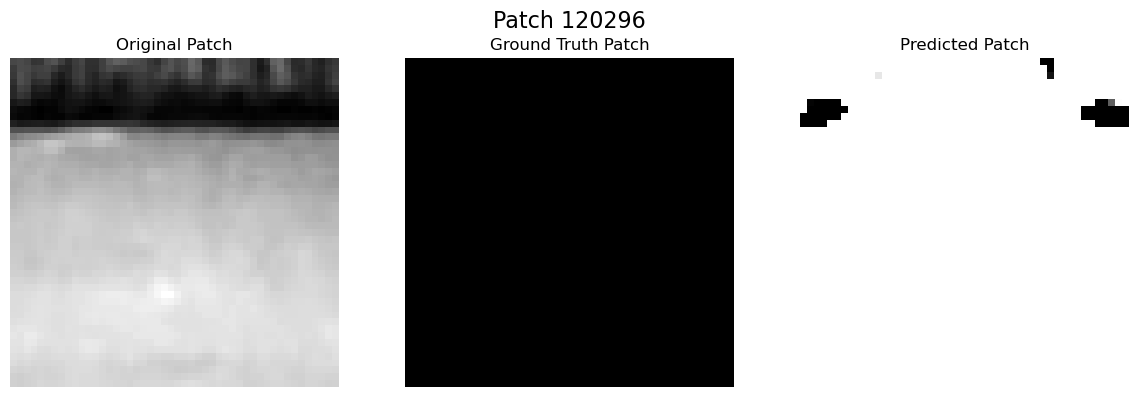

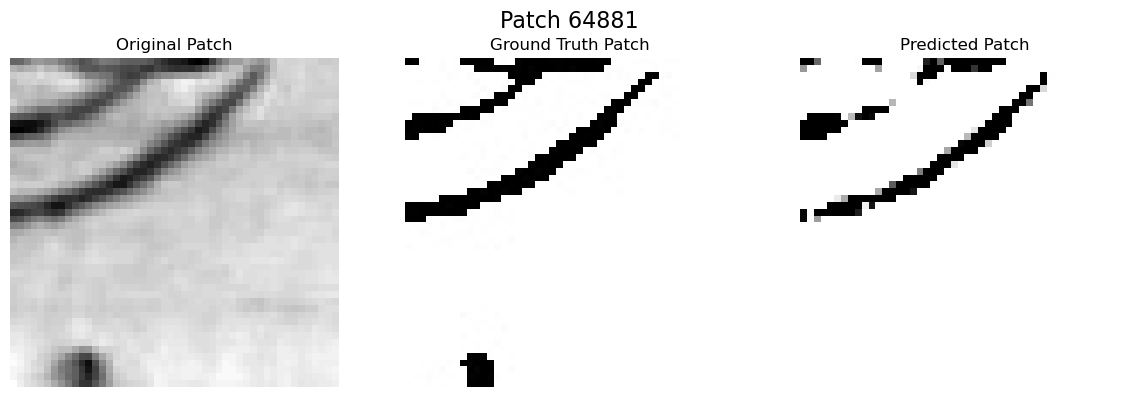

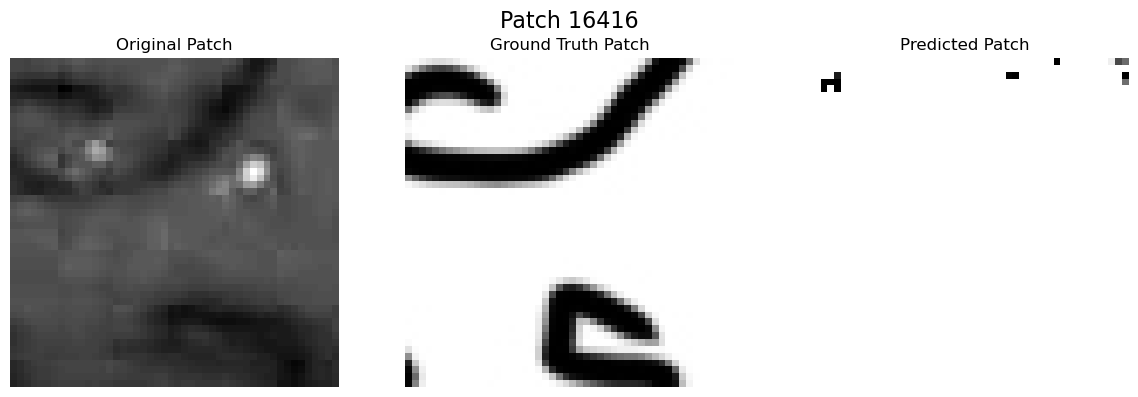

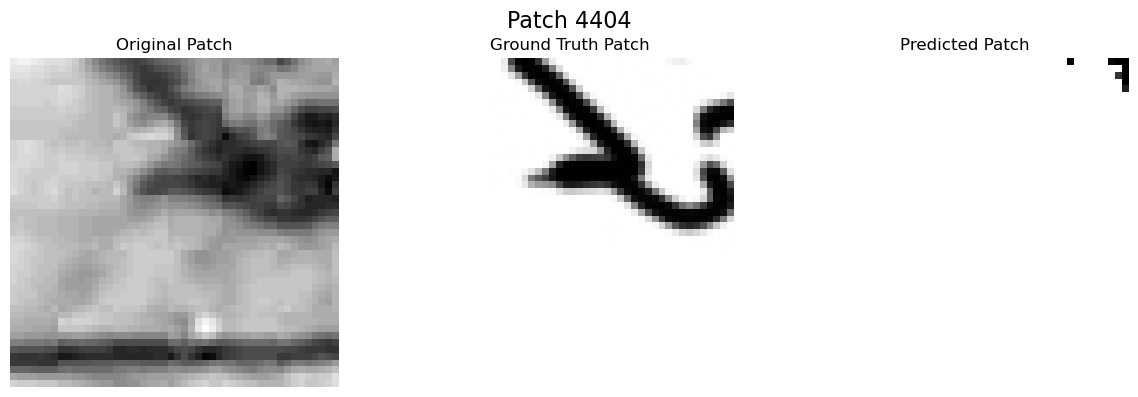

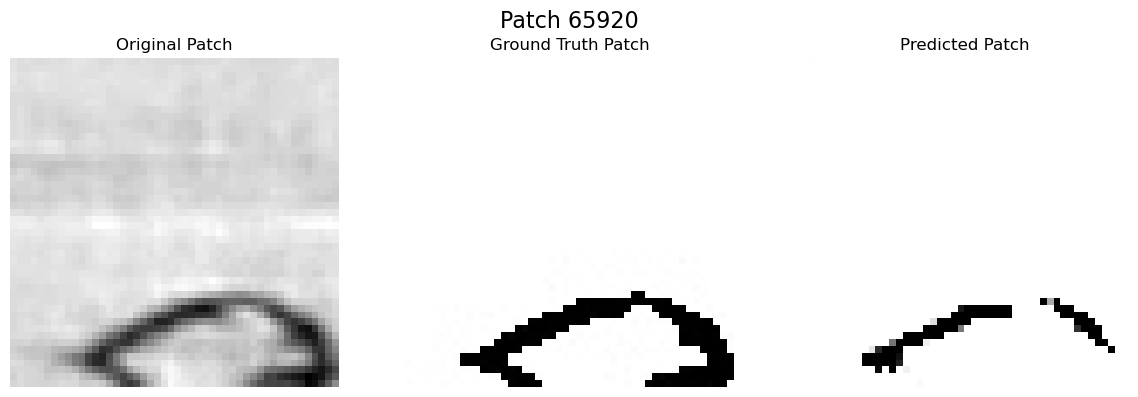

In [8]:
import matplotlib.pyplot as plt
import random

# Function to visualize patches
def plot_patches(original_patch, ground_truth_patch, predicted_patch, index):
    """
    Plots the original, ground truth, and predicted patches side by side.
    """
    plt.figure(figsize=(12, 4))

    # Original Patch
    plt.subplot(1, 3, 1)
    plt.title("Original Patch")
    plt.imshow(original_patch.squeeze().cpu().numpy(), cmap="gray")
    plt.axis("off")

    # Ground Truth Patch
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Patch")
    plt.imshow(ground_truth_patch.squeeze().cpu().numpy(), cmap="gray")
    plt.axis("off")

    # Predicted Patch
    plt.subplot(1, 3, 3)
    plt.title("Predicted Patch")
    plt.imshow(predicted_patch.squeeze(), cmap="gray")
    plt.axis("off")

    plt.suptitle(f"Patch {index}", fontsize=16)
    plt.tight_layout()
    plt.show()


# Visualize a few random patches from the dataset
num_patches_to_visualize = 5  # Adjust the number of patches to display
random_indices = random.sample(range(len(patch_loader.dataset)), num_patches_to_visualize)

for index in random_indices:
    # Get a specific random patch
    original_patch, ground_truth_patch = patch_loader.dataset[index]

    # Move patches to the device and predict output
    original_patch = original_patch.unsqueeze(0).to(device)  # Add batch dimension
    ground_truth_patch = ground_truth_patch.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        predicted_patch = model(original_patch).squeeze(0).cpu().detach().numpy()

    # Plot patches
    plot_patches(original_patch.squeeze(), ground_truth_patch.squeeze(), predicted_patch, index)
